In [1]:
import ast
import csv
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, DataStructs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
filepath = './merged.sdf'
mols = Chem.SDMolSupplier(filepath)

In [3]:
with open('subgraph.csv', 'r', newline='') as r_file:
    csv_reader = csv.DictReader(r_file)
    avg_lap1 = 0
    avg_lap2 = 0
    overlap_num = 0
    som_name = []
    for row in csv_reader:
        # 分子名称，分子顺序索引，分子每个som的一阶二阶邻居节点索引（包含som，位于每个列表的第一个），可解释性重要节点索引提取
        # row['name'], row['n_index'], row['subgraph_node1'], row['subgraph_node2'], row['subgraph']
        subgraph_node1 = ast.literal_eval(row['subgraph_node1'])
        subgraph_node2 = ast.literal_eval(row['subgraph_node2'])
        subgraph = ast.literal_eval(row['subgraph']) 
        name_som_list = []
        # 迭代嵌套列表存放获得的所有som的二阶邻居子图
        all_som = []
        for sub_node_list2 in subgraph_node2:
            sub_im = set(sub_node_list2)&set(subgraph)
            if len(sub_im) != 0:
                all_som.append(list(sub_im))
        som = []
        for som_list in all_som:
            for somlist in som_list:
                som.append(somlist)
        som = set(som)
        name_som_list.append(list(som))
        name_som_list.append(row['name'])
        som_name.append(name_som_list)
#     print(som_name)

In [4]:
len(som_name)

544

In [5]:
submol_list = []
submol_name_list = []
for mol in mols:
    name = mol.GetProp('_Name')
    for somname in som_name:
        try:
            if name == somname[1] and len(somname[0]) != 0:
                submol = Chem.PathToSubmol(mol, somname[0])
                print(name, submol)
                submol_list.append(submol)
                submol_name_list.append([name, submol])
        except Exception as e:
            # 打印错误消息和有问题的项，以便调试
            print(f"An error occurred with {somname}: {e}")

13_cis_retinoic_acid <rdkit.Chem.rdchem.Mol object at 0x7fee0569c2e0>
1_nitropyrene <rdkit.Chem.rdchem.Mol object at 0x7fee0569c4a0>
2-acetylaminofluorene <rdkit.Chem.rdchem.Mol object at 0x7fee0569c270>
2-acetylbenzothiophene <rdkit.Chem.rdchem.Mol object at 0x7fee0569c580>
2-naphthylamine <rdkit.Chem.rdchem.Mol object at 0x7fee0569c660>
2_nitropyrene <rdkit.Chem.rdchem.Mol object at 0x7fee0569c740>
3-cyano-7-ethoxycoumarin <rdkit.Chem.rdchem.Mol object at 0x7fee0569c900>
3-cyano-7-methoxycoumarin <rdkit.Chem.rdchem.Mol object at 0x7fee0569c820>
3-ethoxy-4-trifluoromethylcoumarin <rdkit.Chem.rdchem.Mol object at 0x7fee0569c9e0>
3-methoxy-4-trifluoromethylcoumarin <rdkit.Chem.rdchem.Mol object at 0x7fee0569cac0>
3-methylindole <rdkit.Chem.rdchem.Mol object at 0x7fee0569cc80>
4-aminobiphenyl <rdkit.Chem.rdchem.Mol object at 0x7fee0569cba0>
4_nitropyrene <rdkit.Chem.rdchem.Mol object at 0x7fee0569cd60>
5_methylchrysene <rdkit.Chem.rdchem.Mol object at 0x7fee0569ce40>
6_methylchrysene <rd

[13:44:06] 

****
Range Error
idx
Violation occurred on line 338 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 8 < 8
****

[13:44:06] 

****
Range Error
idx
Violation occurred on line 338 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 4 < 4
****

[13:44:06] 

****
Range Error
idx
Violation occurred on line 338 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 3 < 3
****

[13:44:06] 

****
Range Error
idx
Violation occurred on line 338 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 2 < 2
****

[13:44:06] 

****
Range Error
idx
Violation occurred on line 338 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 3 < 3
****

[13:44:06] 

****
Range Error
idx
Violation occurred on line 338 in file /project/build/temp.linux-x86_64-cpyt

In [6]:
len(submol_list)

421

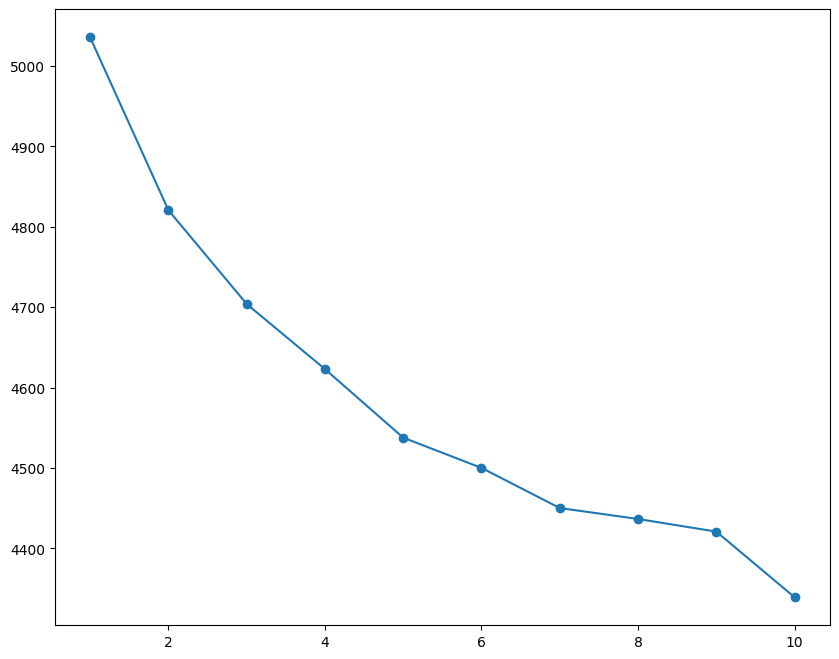

In [7]:
# 初始化环信息
for mol in submol_list:
    Chem.GetSymmSSSR(mol)  # 这将初始化环信息，避免“RingInfo not initialized”的错误

# 生成分子指纹
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in submol_list]

# 转换指纹为 NumPy 数组，便于计算和聚类
fp_array = np.array([list(fp) for fp in fingerprints])  # 将指纹转换为二进制向量形式

# 使用肘部法则确定最佳聚类数
sse = []
for k in range(1, 11):  # 测试1到10个聚类
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(fp_array)
    sse.append(kmeans.inertia_)  # 聚类内误差平方和

# 绘制肘部图
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), sse, marker='o')
# plt.title('Elbow Method For Optimal k')
# plt.xlabel('Number of clusters')
# plt.ylabel('SSE')
plt.savefig('./cluster/Important Submolecular clustering-k-GNN.png')
plt.show()

In [8]:
# 聚类算法 - 使用 K-means
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(fp_array)  # 训练模型

# 获取聚类结果
labels = kmeans.labels_

# 假设 mol_objects 是与 submol_list 相对应的 Mol 对象列表
mol_objects = submol_list  # 确保 mol_objects 真实反映了用于生成指纹的分子列表

In [9]:
# 打印每个分子及其对应的聚类标签
for mol, label in zip(mol_objects, labels):
    print(Chem.MolToSmiles(mol), label)

CC.CC(C)C.CCC 2
ccccc(ccc)c(cc)ccc 4
cc.ccc(c)NC(C)=O 4
ccc.cccc(C)s 4
ccc(c)N 4
ccccc1cc([NH3+])cc(c)c1 4
cc(c)O.co 2
ccO.co 1
cc(c)O.co 2
ccO.co 1
ccc.ccc[nH]c 4
c-c.cc.ccc 4
ccc.cccc(c(c)c)c(cc)cc 4
cccc.cccc(c)c(cc)cc(c)C 4
ccccccc(cc)c(c)c(C)cc 4
cc(c)OC.co 2
cc.ccccnc 4
CC.CC(C)O.cO.ccc 1
ccc(c)OC.co 4
cccccccccc(c)cc 4
ccO.co 1
CF.cc 2
CC.c=O.cc 2
cC.ccc(NCN)c(c)C.ccccc 4
ccC.ccCNC.ccc 4
cc.ccO 1
ccc(c)c(c)c.cccc(c)c(c)c 4
cccc(c)c(c)c.ccccc(c)cC 4
cc 2
CO.ccc(N)cc(c)CCO 4
cOC.cc 2
CC.CN.COccO.cc 1
cccc(C)c(cC)OCC 4
CN.c=O.cc 2
cn 2
Cn.c=O.c=O.cn(c)C 2
CCCCNC.N=O 3
cncc(c)CC 4
CC.cc.cc.ccC=O 1
CC.CCCNN=O 3
cO.cnc[nH]c 2
CC.c=O.cc 2
CC.CF.cc.ccN 1
ccc.cccsc(c)CNC 4
Cc.ccccc 4
C=O.cccoc 1
cc(cCC)oc(=O)cCCC.ccOC 1
cS.cc.cc 2
CC=C(C)CCC 1
C=Cccc.CC.cc.cc.ccc 4
cc-n(c=O)nC.ccC 1
CF.CF.CN.CO.CO.c[nH].cc 2
C/C=C\CCCCC.CC 3
CCN.CCN.cn.ncCl 1
ccc(c)c(c(c)c)c1c(c)cc(c)c(c)c1c 4
cc.cc.cc.ccc(c)cc 4
coc1ccccc1C 0
cn(C)cn(C)c1cn(C)cn1 1
CNCc1ccc(O)c(O)c1 0
cc.cc(ccO)CCC 1
CO.cc.ccc.ccc 4
ccc

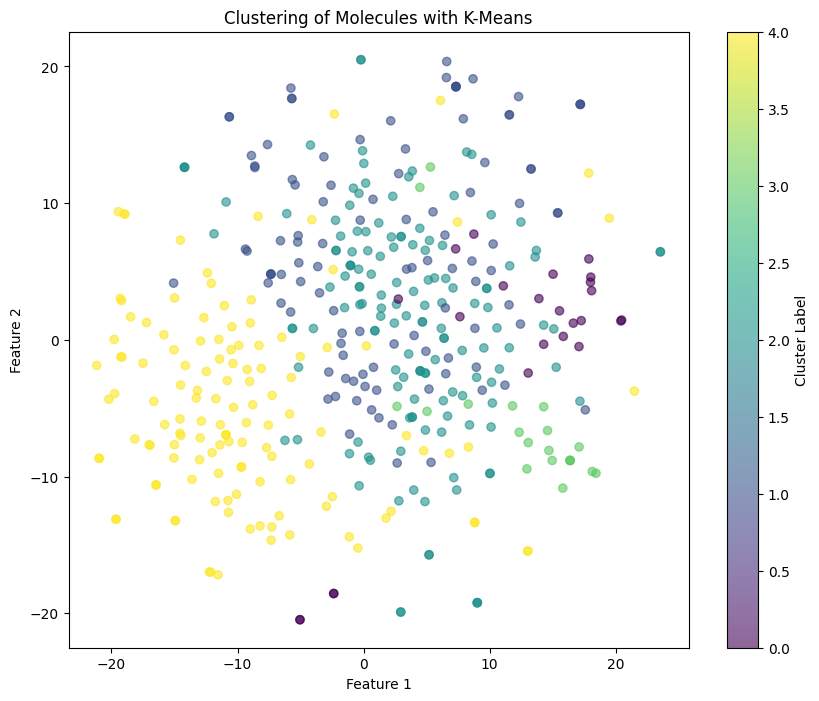

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# 使用t-SNE进行降维，以便在二维空间中可视化
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(fp_array)

# 绘制聚类结果
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title('Clustering of Molecules with K-Means')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, label='Cluster Label')

# 可选：为每个点添加SMILES标签
# for i, mol in enumerate(mol_objects):
#     smiles = Chem.MolToSmiles(mol)
#     plt.annotate(smiles, (reduced_data[i, 0], reduced_data[i, 1]))

plt.show()

421 421


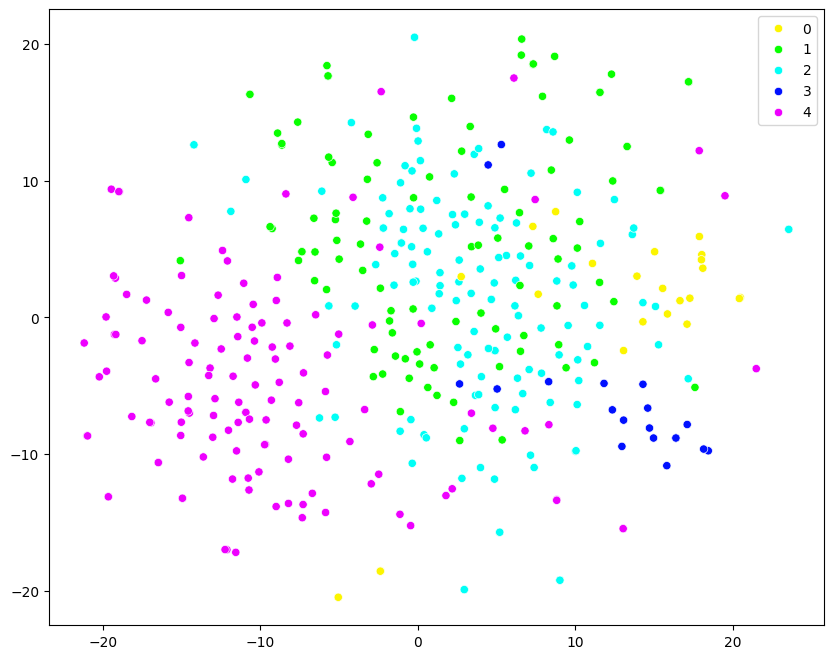

In [10]:
from sklearn.manifold import TSNE
import seaborn as sns

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)
fp_tsne = tsne.fit_transform(fp_array)
print(fp_tsne.shape[0], len(labels))
# 可视化
plt.figure(figsize=(10, 8))
sns.scatterplot(x=fp_tsne[:, 0], y=fp_tsne[:, 1], hue=labels, palette=sns.color_palette("hsv", n_colors=5), legend='full')
# plt.title('Clustering of Molecules')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.legend(title='Cluster')
plt.savefig('./cluster/Important Submolecular clustering-GNN.png')
plt.show()

In [11]:
# 获取聚类中心点
cluster_centers = kmeans.cluster_centers_

# 如果你想查看这些中心点
print("Cluster centers:")
for index, center in enumerate(cluster_centers):
    print(f"Center of Cluster {index}:", center)

Cluster centers:
Center of Cluster 0: [4.16666667e-02 6.93889390e-18 0.00000000e+00 ... 8.67361738e-19
 0.00000000e+00 0.00000000e+00]
Center of Cluster 1: [ 4.33680869e-19  4.76190476e-02  1.90476190e-02 ... -6.07153217e-18
  3.80952381e-02  0.00000000e+00]
Center of Cluster 2: [0.         0.07638889 0.         ... 0.00694444 0.         0.        ]
Center of Cluster 3: [-8.67361738e-19  5.00000000e-02 -1.73472348e-18 ...  0.00000000e+00
 -3.46944695e-18  0.00000000e+00]
Center of Cluster 4: [4.33680869e-19 5.46875000e-02 8.67361738e-19 ... 1.56250000e-02
 1.73472348e-18 0.00000000e+00]


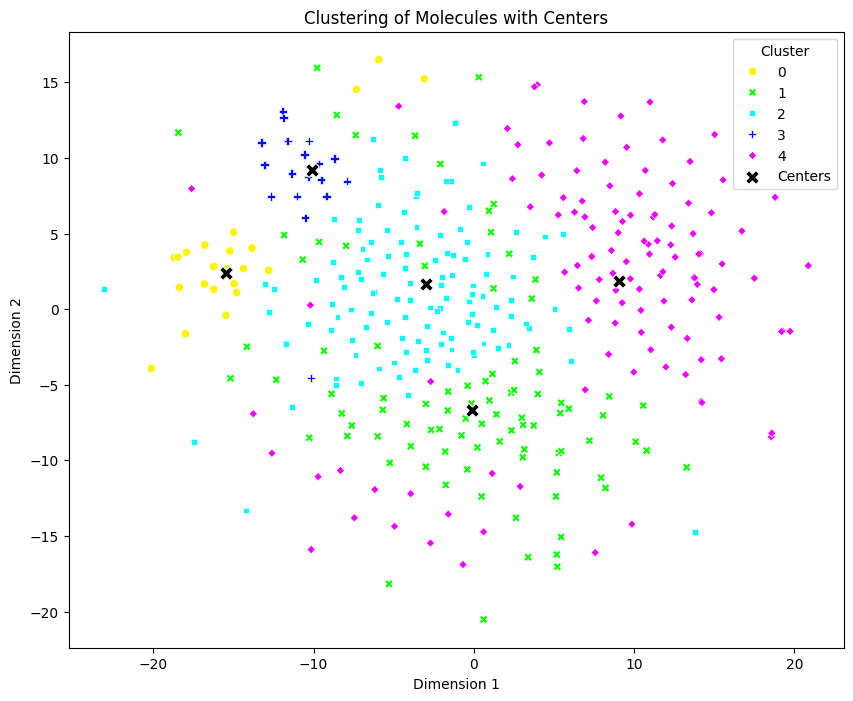

In [12]:
# 先将中心点也用t-SNE降维到二维空间，为了保证降维后的空间一致性，我们需要在包含原始数据点的基础上添加中心点后重新降维
fp_array_with_centers = np.vstack([fp_array, cluster_centers])
tsne = TSNE(n_components=2, random_state=42)
fp_tsne_with_centers = tsne.fit_transform(fp_array_with_centers)

# 分离原始点和中心点
original_points = fp_tsne_with_centers[:-len(cluster_centers), :]
center_points = fp_tsne_with_centers[-len(cluster_centers):, :]

# 绘制散点图
plt.figure(figsize=(10, 8))
sns.scatterplot(x=original_points[:, 0], y=original_points[:, 1], hue=labels, palette=sns.color_palette("hsv", n_colors=5), legend='full', style=labels)
sns.scatterplot(x=center_points[:, 0], y=center_points[:, 1], s=100, color='black', marker='X', label='Centers')
plt.title('Clustering of Molecules with Centers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cluster')
plt.savefig('./cluster/Important Submolecular clustering Central site.png')
plt.show()

In [11]:
from scipy.spatial import distance
closest_indices = []

for i in range(kmeans.n_clusters):
    center = kmeans.cluster_centers_[i]
    # 计算所有分子到该中心的距离
    dists = np.array([distance.euclidean(fp, center) for fp in fp_array])
    # 获取距离最近的三个分子的索引
    closest_idxs = dists.argsort()[:200]
    closest_indices.append(closest_idxs)
    print(closest_indices)
    # 打印结果  
    for idx in closest_idxs:  
        print(f"  Molecule Index: {idx}, Assigned Cluster by K-means: {kmeans.labels_[idx]}, Calculated Closest to Cluster: {i}")

[array([331, 338, 129, 211, 274, 326, 217, 120,  28, 230, 403,  86,  78,
       346, 167, 304, 106,  34, 244, 365,  97, 178, 408, 316, 299,  88,
        82, 144, 105, 247, 265, 248, 231, 241, 103, 315, 293, 110, 166,
       238, 220, 212, 272, 179,  47, 259,  21, 280, 227, 108, 369, 215,
       366, 205, 139, 202, 284, 296, 334, 133, 119, 173,  22,  41, 414,
        89, 276, 357, 142, 150, 352, 360, 307, 376, 412,  33, 383, 236,
       251,   6,   8,  11, 102, 373, 165, 306, 222, 391,  73,   7,   9,
        20,  25,  30, 384, 358, 390, 415, 287, 213, 124,  68, 392, 206,
       266, 242, 210, 158, 224, 268, 209, 378, 162, 132, 194, 138, 207,
       332, 252, 235, 294, 292, 297, 118, 313, 329, 389, 394, 347,  80,
       356, 126, 409, 385,  79, 322, 363,  35, 257, 269, 362,  95, 279,
       175, 328, 232, 221,  94, 146, 387, 309, 155, 301,   4, 163,   0,
       273, 203, 229, 111, 345, 349, 348, 151,  56, 393, 416, 417,  15,
       271, 399, 350,  70, 337, 340, 380, 335, 131, 330, 223, 3

[331, 248, 78, 102, 139]


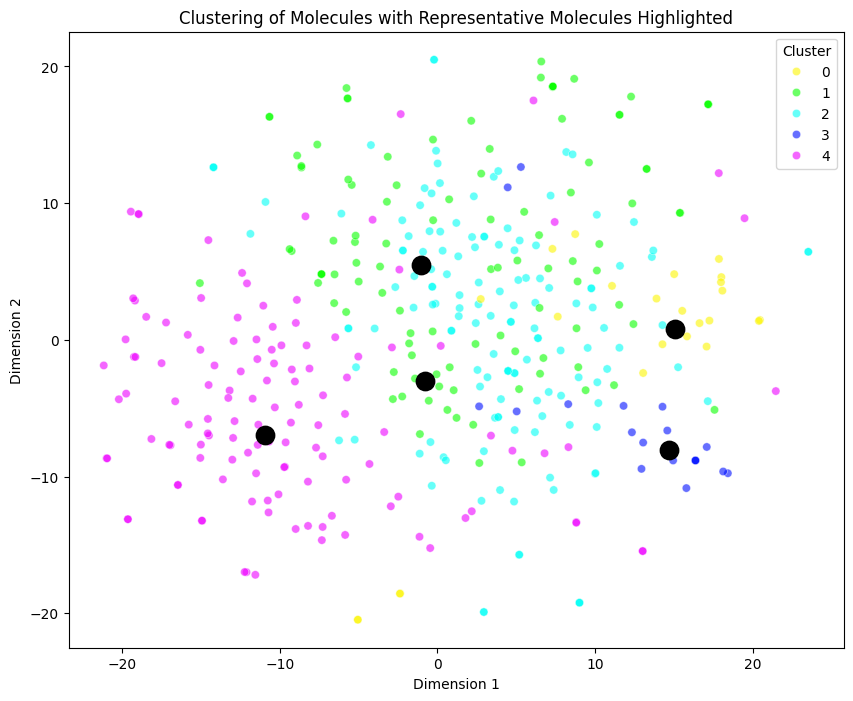

In [120]:
from scipy.spatial import distance
from rdkit.Chem import Draw

# 计算每个聚类中心距离最近的分子
closest_indices = []
for i in range(kmeans.n_clusters):
    center = kmeans.cluster_centers_[i]
    min_dist = np.inf
    closest_index = None
    for idx, fp in enumerate(fp_array):
        dist = distance.euclidean(fp, center)
        if dist < min_dist:
            min_dist = dist
            closest_index = idx
    closest_indices.append(closest_index)
print(closest_indices)
# 绘制所有分子的t-SNE结果
plt.figure(figsize=(10, 8))
sns.scatterplot(x=fp_tsne[:, 0], y=fp_tsne[:, 1], hue=labels, palette=sns.color_palette("hsv", n_colors=kmeans.n_clusters), legend='full', alpha=0.6)

# 标注最具代表性的分子
for idx in closest_indices:
    plt.scatter(fp_tsne[idx, 0], fp_tsne[idx, 1], color='black', s=150, linewidth=2)   # edgecolors='yellow',

plt.title('Clustering of Molecules with Representative Molecules Highlighted')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cluster')
plt.savefig('./cluster/Important Submolecular clustering Classical molecules.png')
plt.show()

[array([331, 338, 129]), array([248,  86,  78]), array([ 78, 230,  86]), array([102, 335, 340]), array([202, 139, 205])]

In [11]:
print(submol_name_list[338], '\n', submol_name_list[129], '\n', submol_name_list[105])
print(submol_name_list[133], '\n', submol_name_list[391], '\n', submol_name_list[287])
print(submol_name_list[68], '\n', submol_name_list[158], '\n', submol_name_list[209])
print(submol_name_list[162], '\n', submol_name_list[194], '\n', submol_name_list[329])
print(submol_name_list[356], '\n', submol_name_list[385], '\n', submol_name_list[175])
print(submol_name_list[56], '\n', submol_name_list[399], '\n', submol_name_list[148])
print('-------------------------------------------------------')
print(submol_name_list[248], '\n', submol_name_list[173], '\n', submol_name_list[227])
print(submol_name_list[25], '\n', submol_name_list[7], '\n', submol_name_list[20])
print(submol_name_list[9], '\n', submol_name_list[89], '\n', submol_name_list[376], '\n', submol_name_list[132])
print('-------------------------------------------------------')
print(submol_name_list[78], '\n', submol_name_list[230], '\n', submol_name_list[86])
print(submol_name_list[403], '\n', submol_name_list[120], '\n', submol_name_list[28])
print(submol_name_list[326], '\n', submol_name_list[217], '\n', submol_name_list[274], '\n', submol_name_list[106])
print('-------------------------------------------------------')
print(submol_name_list[102], '\n', submol_name_list[335], '\n', submol_name_list[340])
print(submol_name_list[337], '\n', submol_name_list[380], '\n', submol_name_list[91])
print(submol_name_list[39], '\n', submol_name_list[181], '\n', submol_name_list[183])
print('-------------------------------------------------------')
print(submol_name_list[202], '\n', submol_name_list[139], '\n', submol_name_list[205])
print(submol_name_list[316], '\n', submol_name_list[276], '\n', submol_name_list[313])
print(submol_name_list[11], '\n', submol_name_list[142], '\n', submol_name_list[392])
print(submol_name_list[251], '\n', submol_name_list[242], '\n', submol_name_list[273])
print(submol_name_list[165], '\n', submol_name_list[345], '\n', submol_name_list[126])
print(submol_name_list[232], '\n', submol_name_list[398], '\n', submol_name_list[383])

['p-xylene', <rdkit.Chem.rdchem.Mol object at 0x7fee05613f20>] 
 ['ortho_dichlorobenzene', <rdkit.Chem.rdchem.Mol object at 0x7fee056804a0>] 
 ['m-xylene', <rdkit.Chem.rdchem.Mol object at 0x7fee0567deb0>]
['para_cresol', <rdkit.Chem.rdchem.Mol object at 0x7fee056809e0>] 
 ['naphthalene', <rdkit.Chem.rdchem.Mol object at 0x7fee05618f20>] 
 ['suprofen', <rdkit.Chem.rdchem.Mol object at 0x7fee0560f040>]
['coumarin', <rdkit.Chem.rdchem.Mol object at 0x7fee05679040>] 
 ['terbinafine', <rdkit.Chem.rdchem.Mol object at 0x7fee05683040>] 
 ['diclofenac', <rdkit.Chem.rdchem.Mol object at 0x7fee05606c80>]
['ticlopidine', <rdkit.Chem.rdchem.Mol object at 0x7fee05683200>] 
 ['indole', <rdkit.Chem.rdchem.Mol object at 0x7fee05684e40>] 
 ['raloxifene', <rdkit.Chem.rdchem.Mol object at 0x7fee05613820>]
['aripiprazole', <rdkit.Chem.rdchem.Mol object at 0x7fee05615f20>] 
 ['kr_33028', <rdkit.Chem.rdchem.Mol object at 0x7fee056189e0>] 
 ['2n_propylquinoline', <rdkit.Chem.rdchem.Mol object at 0x7fee05683

In [78]:
submol_name_list[331]

['benzene', <rdkit.Chem.rdchem.Mol at 0x7f181e104350>]

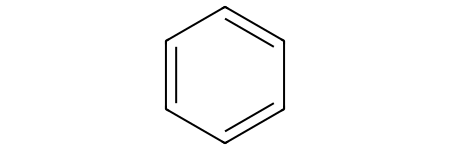

In [79]:
submol_list[331]

In [72]:
submol_name_list[248]

['indomethacin_phenethylamide', <rdkit.Chem.rdchem.Mol at 0x7f181e170b30>]

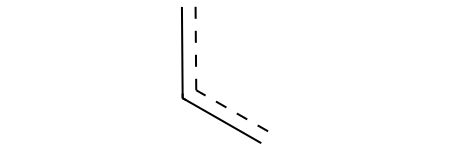

In [80]:
submol_list[248]

In [81]:
submol_name_list[78]

['diphenhydramine', <rdkit.Chem.rdchem.Mol at 0x7f181e8a6270>]

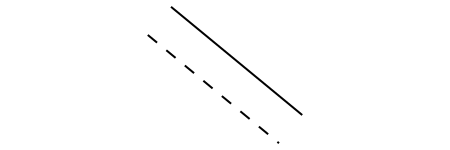

In [82]:
submol_list[78]

In [83]:
submol_name_list[102]

['linoleic_acid', <rdkit.Chem.rdchem.Mol at 0x7f181e38b900>]

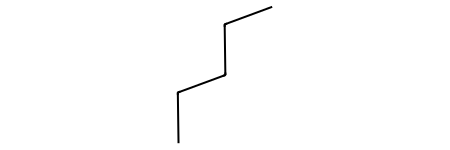

In [84]:
submol_list[102]

In [91]:
submol_name_list[139]

['pimobendan', <rdkit.Chem.rdchem.Mol at 0x7f181e641970>]

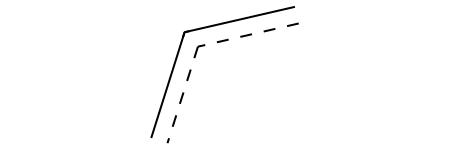

In [92]:
submol_list[139]